<div style="text-align:center">
    <h1>Supernovae times and locations</h1>
    <p style="text-align:center">FIRE (and other codes) currently assume that all supernova happen within their parent cluster and also end after 37.53 Myr. Let's investigate whether that is actually the case</p>
</div>

In [4]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [5]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load the population

In [6]:
%%time
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/boundedness/alpha_1.0")

CPU times: user 3min 16s, sys: 1min 22s, total: 4min 38s
Wall time: 5min 8s


In [7]:
f'Total mass of sim: {(p.mass_binaries + p.mass_singles) * u.Msun:1.3e}'

'Total mass of sim: 1.017e+08 solMass'

In [8]:
%%time
p.final_coords

CPU times: user 6min 28s, sys: 18.6 s, total: 6min 47s
Wall time: 6min 35s


(<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
     (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
     [( -3.7581789 ,  33.69791105, -21.65011554),
      (-27.61580623,  33.88422159, -18.18235008),
      ( -5.25303493, -32.70556364, -14.6923903 ), ...,
      (  7.32363114,  -5.2973229 ,   0.37416403),
      (-52.61997648, -26.63990237, 156.81892561),
      (  7.13487631,  -4.67559782,   0.27836492)]
  (v_x, v_y, v_z) in km / s
     [(-126.52792447,  292.47594452, -306.33609185),
      (-252.04662301,  189.4657599 , -139.1028332 ),
      (-112.8613438 , -204.79519311, -105.03579822), ...,
      (  31.88878588,   89.37559581,  -13.56168502),
      (-192.26948519, -105.71351493,  668.57783119),
      (  31.51966799,   92.0793009 ,  -14.15940209)]>,
 <SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
     (266.4051, -28.936175)>, galcen_distance

In [9]:
get_rid_of_wacky_ones = p.bin_nums[~np.isin(p.bin_nums, [461594, 1950133])]

In [10]:
%%time
p = p[get_rid_of_wacky_ones]

CPU times: user 1min 37s, sys: 1min 25s, total: 3min 3s
Wall time: 3min 3s


# Supernova times

First let's consider the when since we just need COSMIC for that

In [11]:
import sys
sys.path.append("helpers/")
import tomFIRE

In [12]:
recent_stars = tomFIRE.FIRESnapshot(particle_type="star", min_t_form=13.6 * u.Gyr)

In [13]:
supernova_bin_nums = p.bpp[(p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)]["bin_num"].unique()

## Relative to cluster birth

The important time is relative to the cluster birth for comparing with FIRE

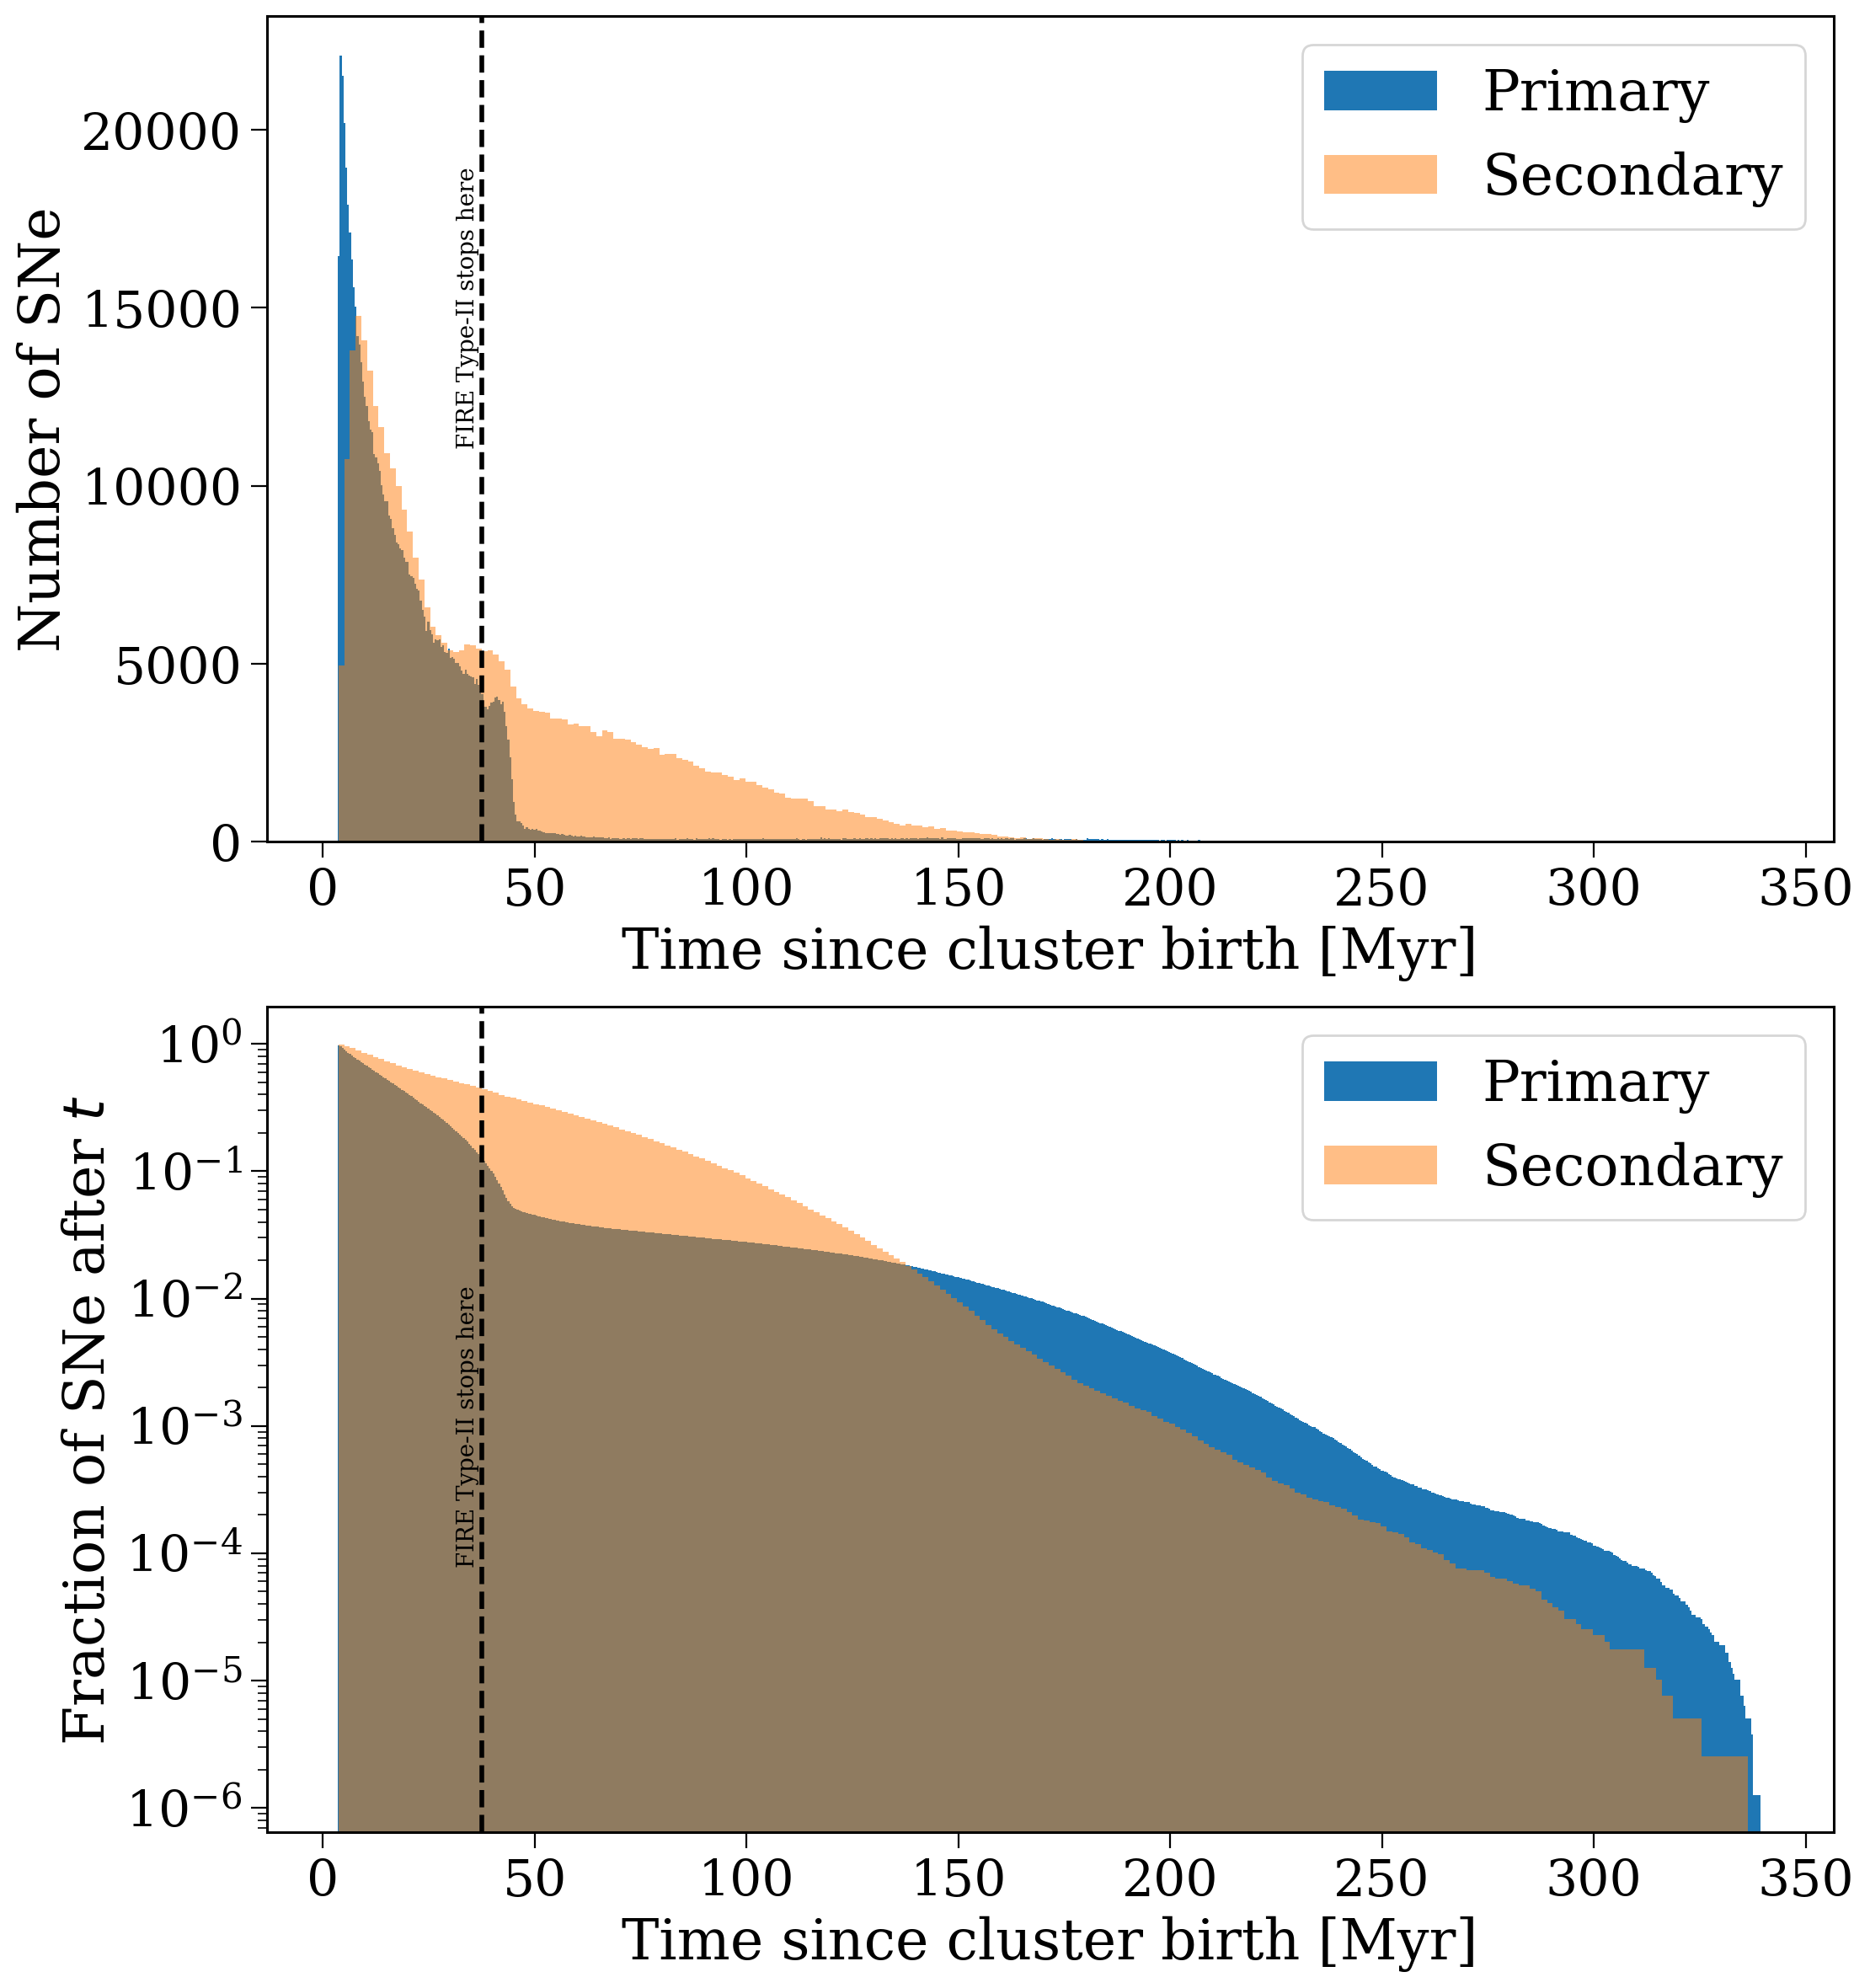

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

for ax, cumulative in zip(axes, [False, True]):
    for sn, alpha, label in zip([15, 16], [1, 0.5], ["Primary", "Secondary"]):
        bin_nums_sn = p.bpp[p.bpp["evol_type"] == sn]["bin_num"].values
        if cumulative:
            hist, bins = np.histogram(p.bpp[p.bpp["evol_type"] == sn]["tphys"], bins="fd", density=False)
            bin_centres = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
            ax.bar(bin_centres, 1 - np.cumsum(hist) / np.sum(hist), width=bin_centres[1] - bin_centres[0], alpha=alpha, label=label)
            ax.set_yscale("log")
            ax.set_ylabel(r"Fraction of SNe after $t$")
        else:
            ax.hist(p.bpp[p.bpp["evol_type"] == sn]["tphys"], bins="fd", alpha=alpha, label=label);
            ax.set_ylabel("Number of SNe")
    
    ax.axvline(37.53, linestyle="--", color="black", lw=2)
    ax.annotate("FIRE Type-II stops here", xy=(37, 1e-3 if cumulative else 15000), rotation=90, color="black", va="center", ha="right")
    
    ax.set_xlabel("Time since cluster birth [Myr]")
    ax.legend()


plt.show()

## Relative to fixed time

It's also interesting to see how the supernova rate changes over the evolution of the galaxy

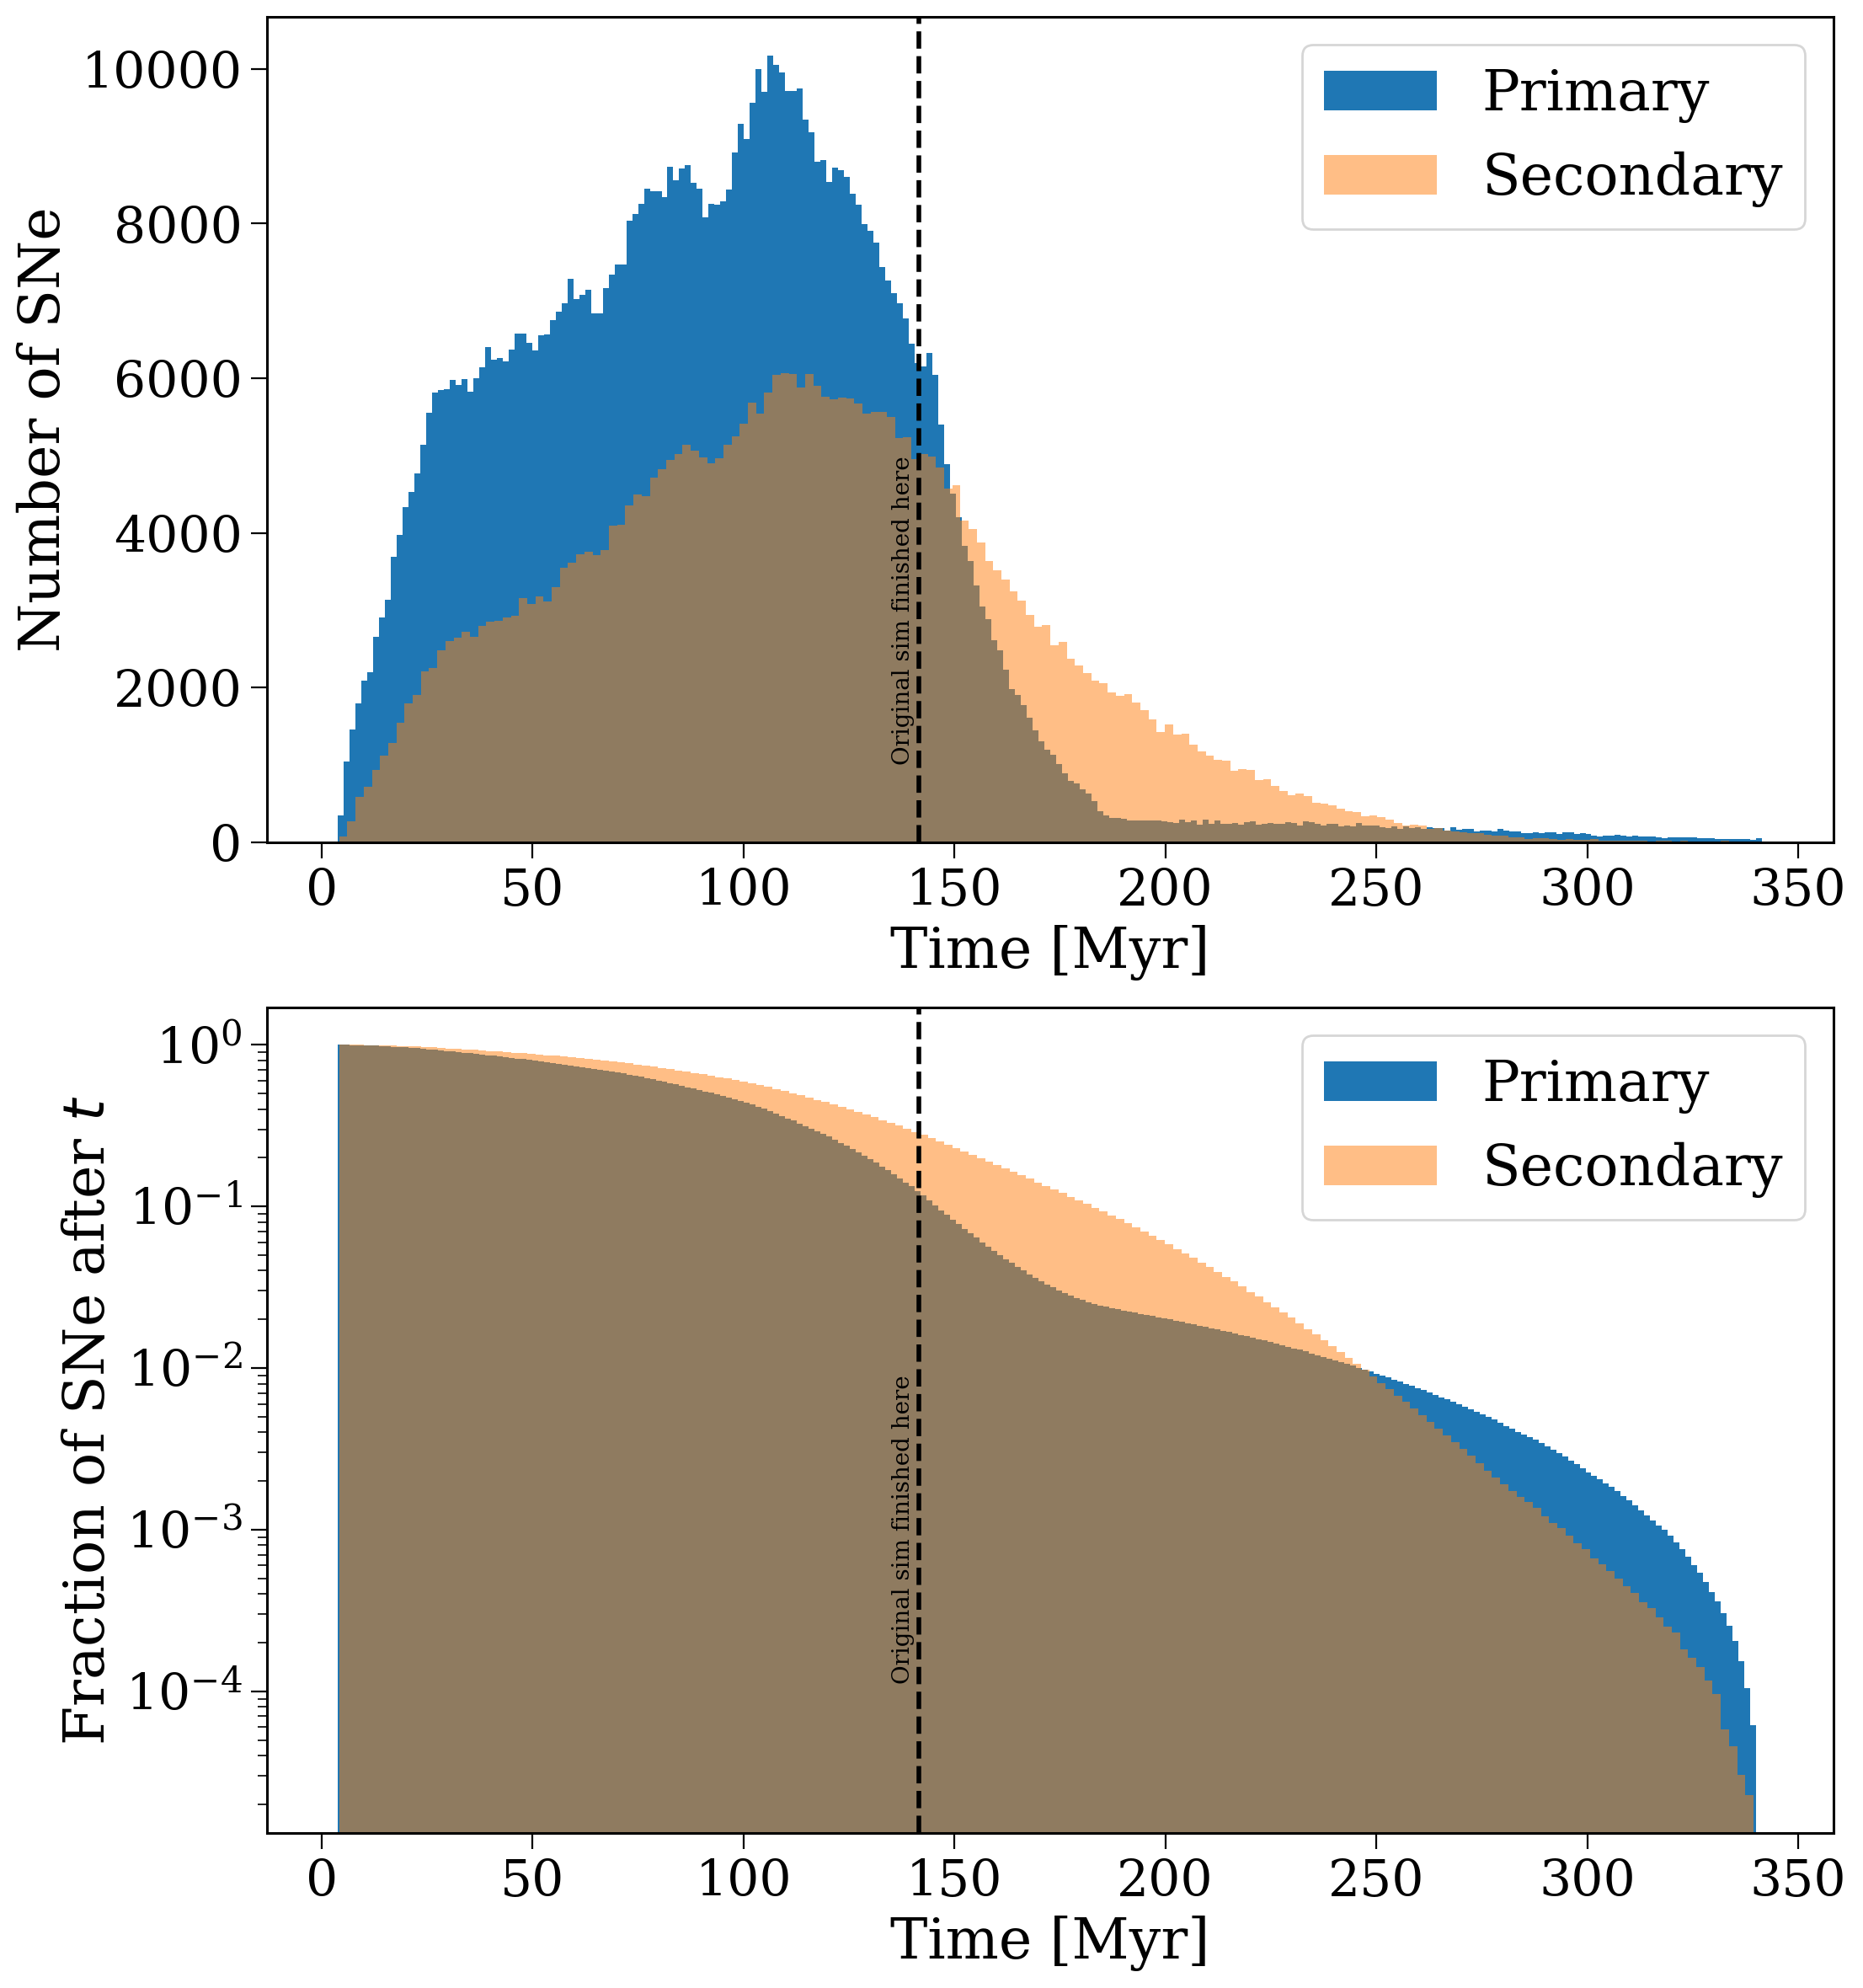

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

offset_to_zero = (p.max_ev_time - 13.6 * u.Gyr - p.initial_galaxy.tau).to(u.Myr).value

for ax, cumulative in zip(axes, [False, True]):
    for sn, alpha, label in zip([15, 16], [1, 0.5], ["Primary", "Secondary"]):
        bin_nums_sn = p.bpp[p.bpp["evol_type"] == sn]["bin_num"].values
        if cumulative:
            hist, bins = np.histogram(p.bpp[p.bpp["evol_type"] == sn]["tphys"] + offset_to_zero[np.isin(p.bin_nums, bin_nums_sn)],
                                      bins="fd", density=False)
            bin_centres = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
            ax.bar(bin_centres, 1 - np.cumsum(hist) / np.sum(hist), width=bin_centres[1] - bin_centres[0], alpha=alpha, label=label)
            ax.set_yscale("log")
            ax.set_ylabel(r"Fraction of SNe after $t$")
        else:
            ax.hist(p.bpp[p.bpp["evol_type"] == sn]["tphys"] + offset_to_zero[np.isin(p.bin_nums, bin_nums_sn)],
                    bins="fd", alpha=alpha, label=label);
            ax.set_ylabel("Number of SNe")
    
    sim_time = (p.max_ev_time - 13.6 * u.Gyr - 200 * u.Myr).to(u.Myr).value
    ax.axvline(sim_time, linestyle="--", color="black", lw=2)
    ax.annotate("Original sim finished here", xy=(sim_time - 1, 1e-3 if cumulative else 3000),
                rotation=90, color="black", va="center", ha="right")
    
    ax.set_xlabel("Time [Myr]")
    ax.legend()


plt.show()

# Supernova locations

Okay now let's look at where these supernovae actually go off

## Prep star particles

In [16]:
%%time
star_particles = pd.read_hdf("FIRE_star_particles.h5")
try:
    particle_orbits = np.load("particle_orbits.npy", allow_pickle=True)
except:
    particle_orbits = [None for _ in range(len(star_particles))]
    for i in range(len(star_particles)):
        if i % 1000 == 0:
            print(i)
        w0 = gd.PhaseSpacePosition(pos=star_particles.iloc[i][["x", "y", "z"]].values * u.kpc,
                                vel=star_particles.iloc[i][["v_x", "v_y", "v_z"]].values * u.km / u.s)
        min_dt = (p.max_ev_time - star_particles.iloc[i]["t_form"] * u.Gyr).to(u.Myr).value
        if min_dt <= 0.01:
            continue
        particle_orbits[i] = p.galactic_potential.integrate_orbit(w0,
                                                                  t1=star_particles.iloc[i]["t_form"] * u.Gyr,
                                                                  t2=p.max_ev_time,
                                                                  dt=min(min_dt - 0.01, 1) * u.Myr)
    np.save("particle_orbits.npy", particle_orbits)

CPU times: user 495 ms, sys: 108 ms, total: 603 ms
Wall time: 603 ms


## Calculate distances for primaries and secondaries

In [17]:
was_kicked = (p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)
kicked_bin_nums = p.bpp["bin_num"][was_kicked].values
kicked_mask = np.isin(p.bin_nums, kicked_bin_nums)

In [18]:
primary_kicked_nums = p.bpp[p.bpp["evol_type"] == 15]["bin_num"].values
secondary_kicked_nums = p.bpp[p.bpp["evol_type"] == 16]["bin_num"].values

In [19]:
primary_sn_rows = p.bpp[p.bpp["evol_type"] == 15]
secondary_sn_rows = p.bpp[p.bpp["evol_type"] == 15]

In [20]:
primary_kicked_mask = np.isin(p.bin_nums, primary_kicked_nums)
secondary_kicked_mask = np.isin(p.bin_nums, secondary_kicked_nums)

In [25]:
p.orbits[primary_kicked_mask][0][0].pos.xyz

<Quantity [10.86734897, -1.92305065,  0.81074928] kpc>

In [27]:
%%time
primary_sn_distances = np.zeros(len(primary_kicked_nums)) * u.kpc
primary_sn_locations = np.zeros((len(primary_kicked_nums), 3)) * u.kpc
child_orbits = p.orbits[primary_kicked_mask]
parent_orbits = particle_orbits[p.initC.loc[primary_kicked_nums]["particle_id"].values]
for i in range(len(primary_kicked_nums)):
    parent_orbit = parent_orbits[i]
    child_orbit = child_orbits[i]
    if isinstance(child_orbit, list):
        child_orbit = child_orbit[0]

    sn_time = primary_sn_rows["tphys"].iloc[i]

    parent_pos = parent_orbit.pos[np.argmin(abs(parent_orbit.t - (sn_time * u.Myr + parent_orbit.t[0])))]
    child_pos = child_orbit.pos[np.argmin(abs(child_orbit.t - (sn_time * u.Myr + child_orbit.t[0])))]

    primary_sn_distances[i] = sum((parent_pos - child_pos).xyz**2)**(0.5)
    primary_sn_locations[i] = child_pos.xyz

CPU times: user 7min 26s, sys: 9.52 s, total: 7min 36s
Wall time: 7min 31s


In [28]:
%%time
secondary_sn_distances = np.zeros(len(secondary_kicked_nums)) * u.kpc
secondary_sn_locations = np.zeros((len(secondary_kicked_nums), 3)) * u.kpc
child_orbits = p.orbits[secondary_kicked_mask]
parent_orbits = particle_orbits[p.initC.loc[secondary_kicked_nums]["particle_id"].values]
for i in range(len(secondary_kicked_nums)):
    parent_orbit = parent_orbits[i]
    child_orbit = child_orbits[i]
    if isinstance(child_orbit, list):
        child_orbit = child_orbit[1]

    sn_time = secondary_sn_rows["tphys"].iloc[i]

    parent_pos = parent_orbit.pos[np.argmin(abs(parent_orbit.t - (sn_time * u.Myr + parent_orbit.t[0])))]
    child_pos = child_orbit.pos[np.argmin(abs(child_orbit.t - (sn_time * u.Myr + child_orbit.t[0])))]

    secondary_sn_distances[i] = sum((parent_pos - child_pos).xyz**2)**(0.5)
    secondary_sn_locations[i] = child_pos.xyz

CPU times: user 3min 43s, sys: 5.6 s, total: 3min 49s
Wall time: 3min 46s


## Plot some distributions!

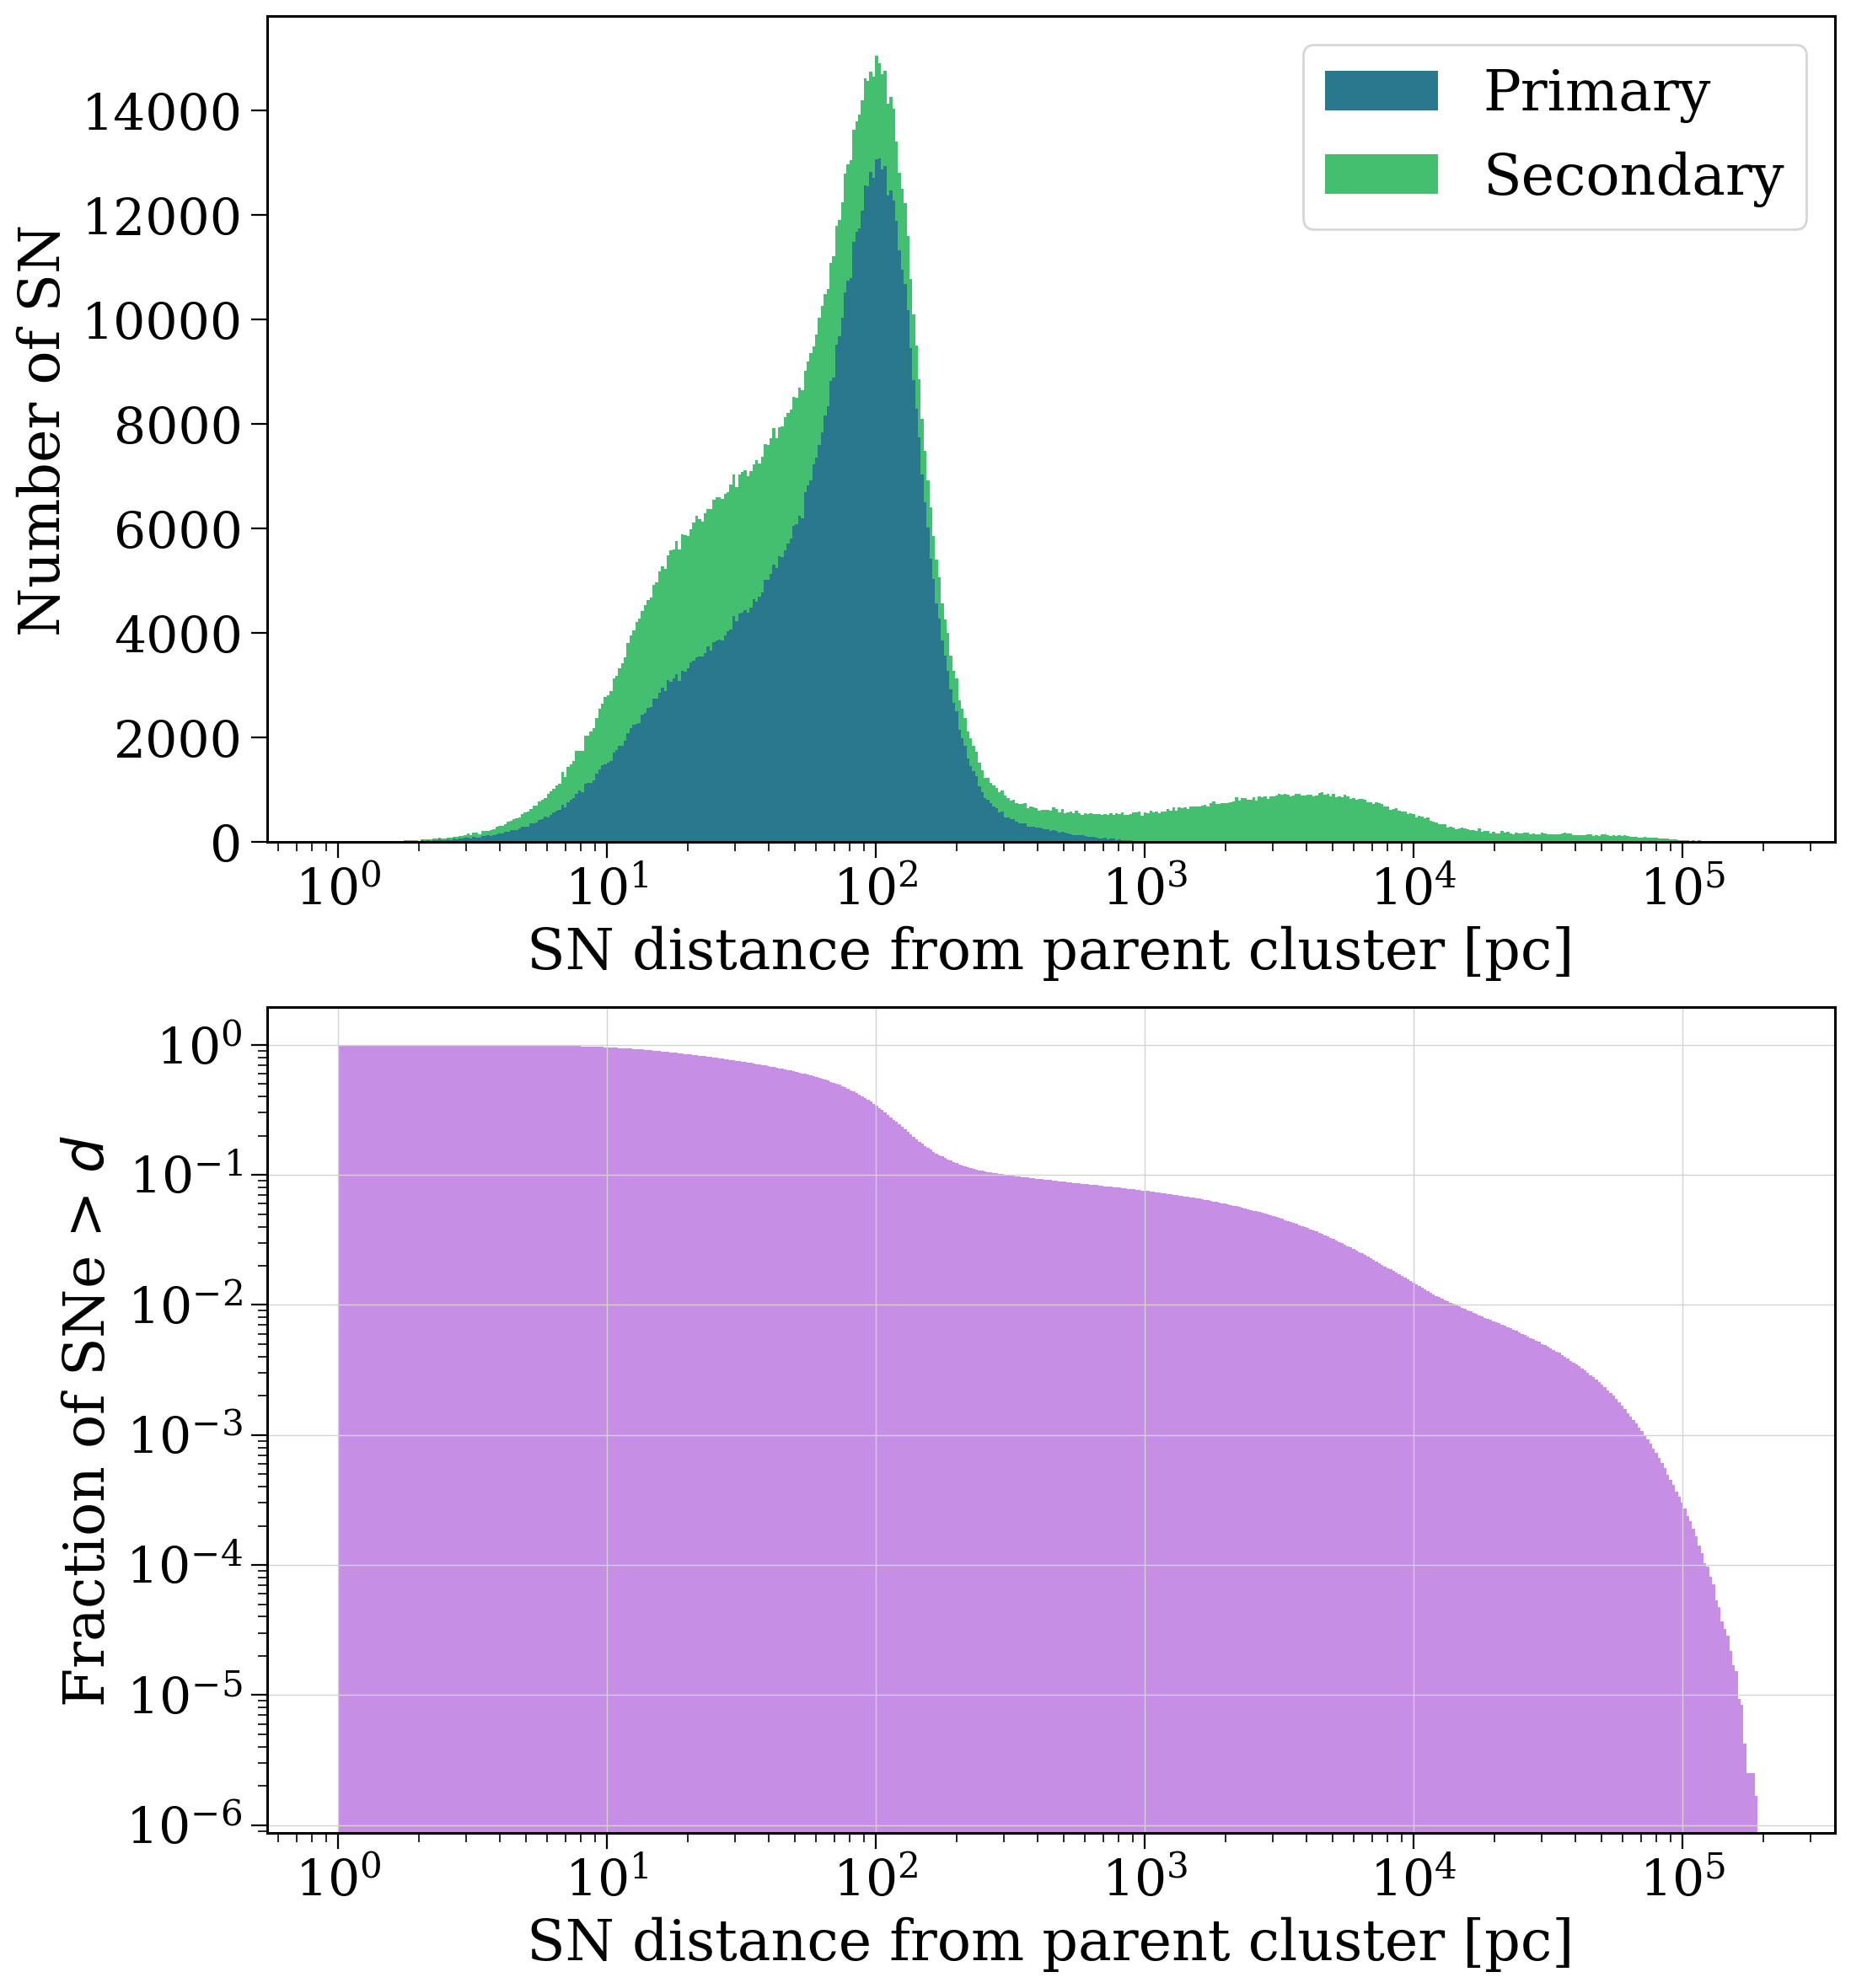

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

bins = np.geomspace(1e0, 2e5, 500)
bin_centres = np.array([(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)])
widths = np.insert(bin_centres[1:] - bin_centres[:-1], -1, bin_centres[1] - bin_centres[0])

ax = axes[0]
ax.hist([primary_sn_distances.to(u.pc).value, secondary_sn_distances.to(u.pc).value],
        bins=bins, label=["Primary", "Secondary"], stacked=True,
        color=[plt.cm.viridis(0.4), plt.cm.viridis(0.7)]);
ax.legend()
ax.set_ylabel(ylabel="Number of SN")

ax = axes[1]
phist, bins = np.histogram(primary_sn_distances.to(u.pc).value, bins=bins)
shist, bins = np.histogram(secondary_sn_distances.to(u.pc).value, bins=bins)
hist = phist + shist
ax.bar(bin_centres, 1 - np.cumsum(hist) / np.sum(hist), width=widths, color="#c78ee6")
ax.set_yscale("log")
ax.set_ylabel(r"Fraction of SNe > $d$")
ax.grid(linewidth=0.5, color="lightgrey")

for ax in axes:
    ax.set(xscale="log", xlabel="SN distance from parent cluster [pc]")
    
plt.show()

### Playing with kicks

In [65]:
kicks = p.kick_info[p.kick_info["natal_kick"] > 0.0]

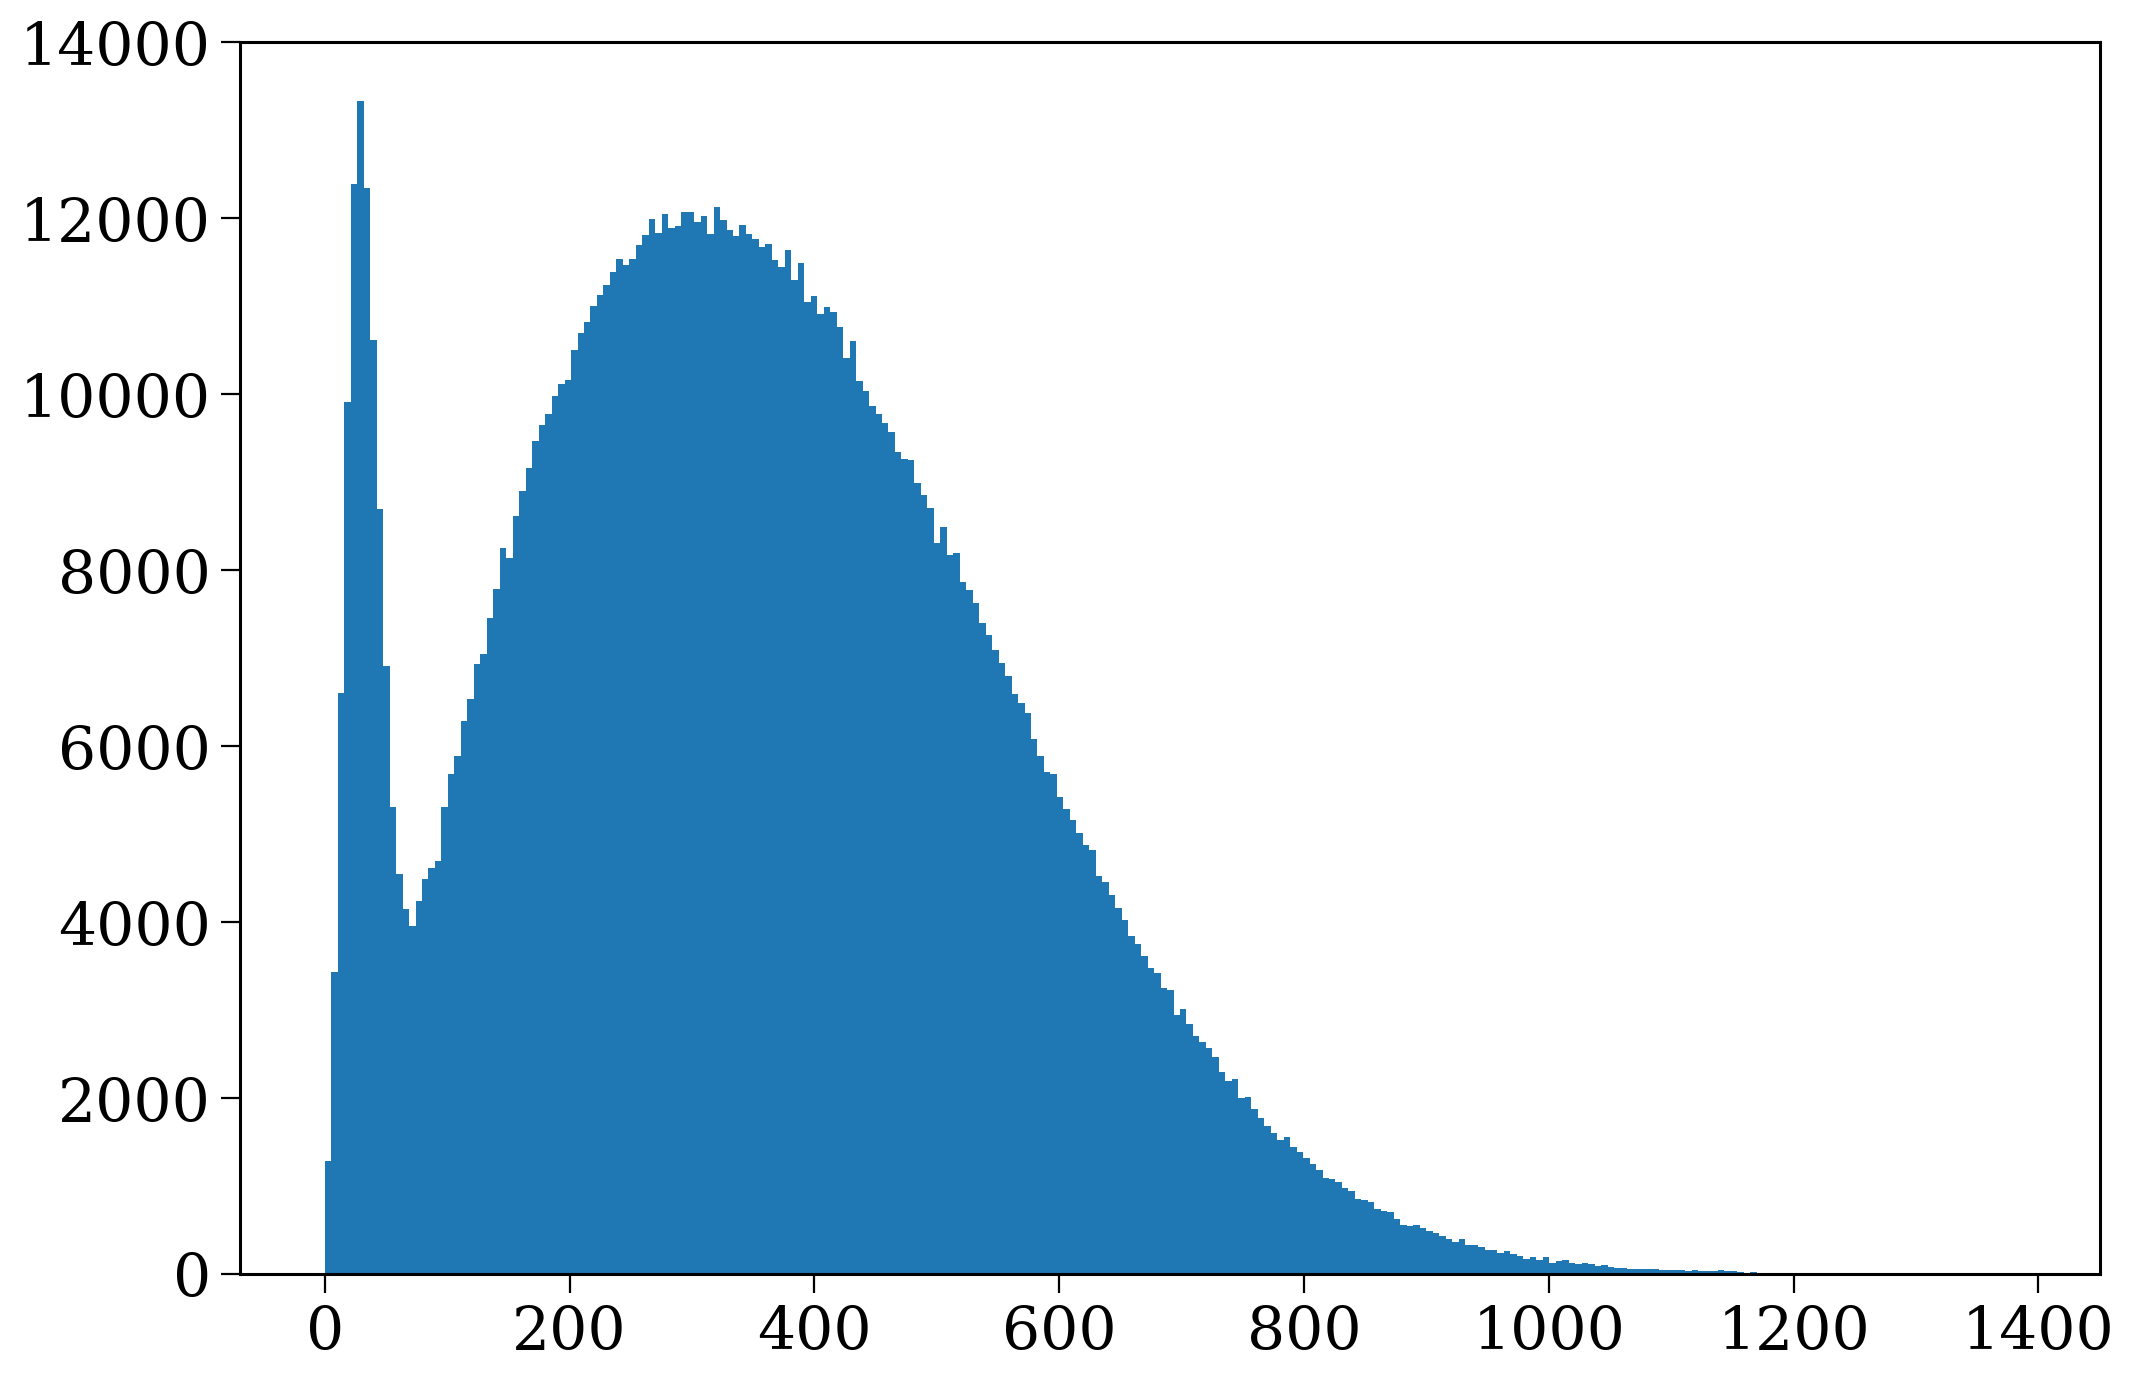

In [68]:
plt.hist(kicks["natal_kick"], bins="fd");

## Old mass bin things

In [ ]:
sn_distances_hists = [sn_distances[(p.initC.loc[kicked_bin_nums]["mass_1"].values <= 15)], sn_distances[(p.initC.loc[kicked_bin_nums]["mass_1"].values > 15)]]

16265
11154
10571
5873
4377


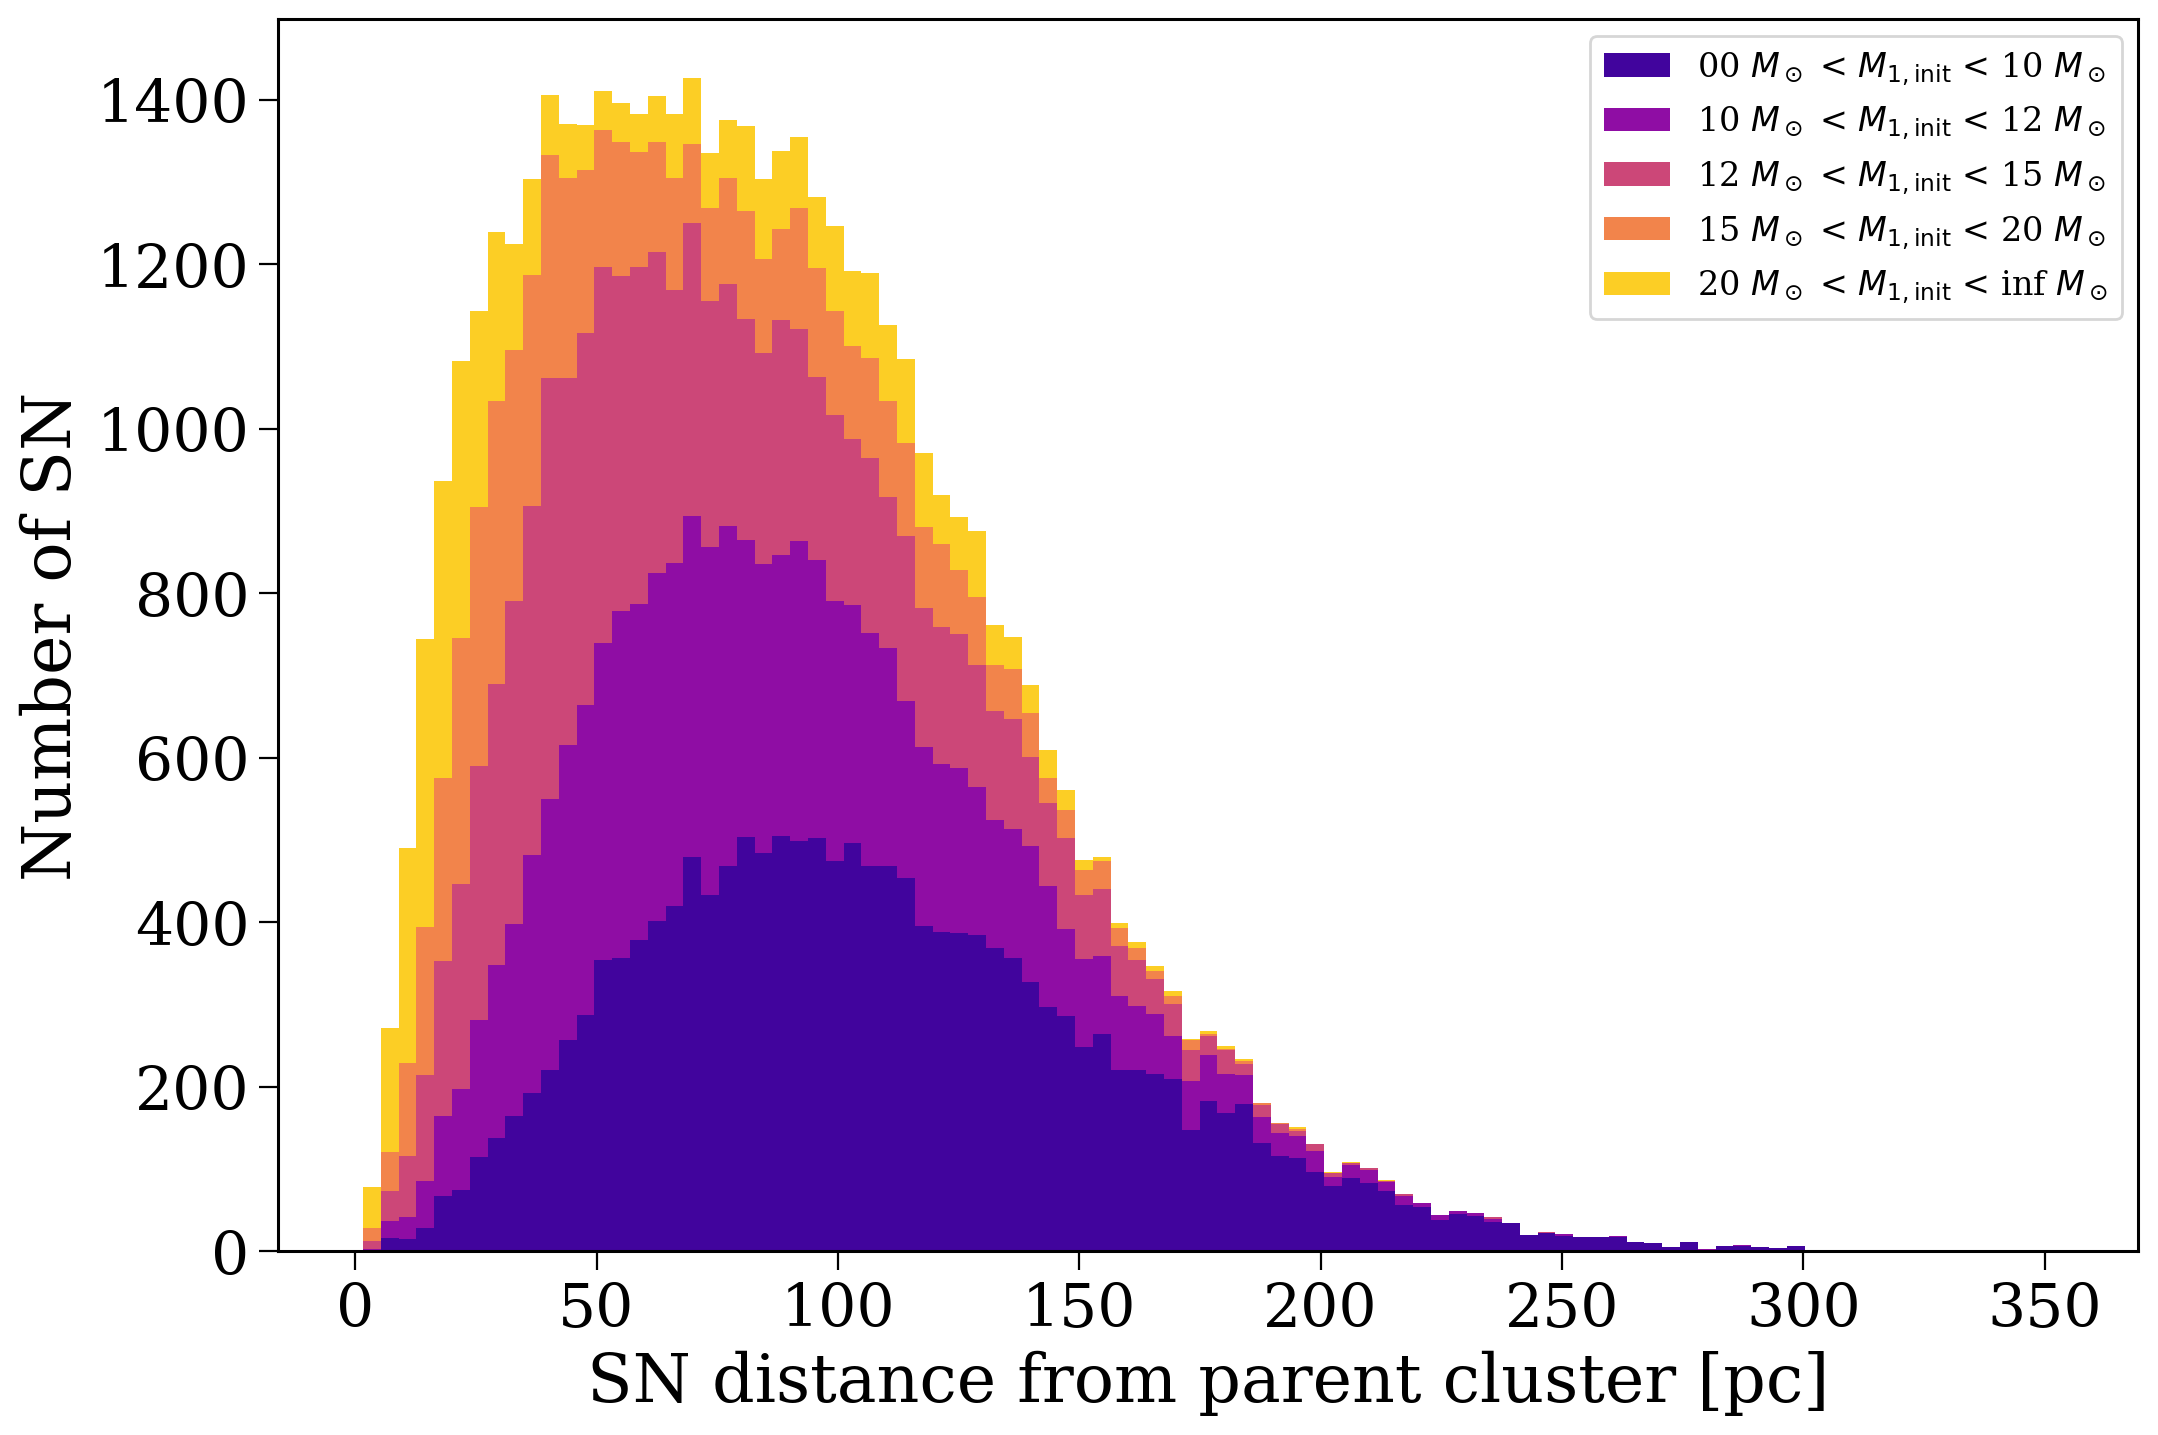

In [ ]:
mass_ranges = [(0, 10), (10, 12), (12, 15), (15, 20), (20, np.inf)]
mass_1_kicked = p.initC.loc[kicked_bin_nums]["mass_1"].values
sn_distances_hists = [sn_distances[(mass_1_kicked >= m_low) & (mass_1_kicked < m_high)].to(u.pc) for m_low, m_high in mass_ranges]

for x in sn_distances_hists:
    print(len(x))

labels = [f"{m_low:02d} $M_\odot$ < $M_{{1, \\rm init}}$ < {m_high} $M_\odot$" for m_low, m_high in mass_ranges]

plt.hist(sn_distances_hists, stacked=True, bins="fd", label=labels,
         color=plt.cm.plasma(np.linspace(0.1, 0.9, len(mass_ranges))));
plt.xlabel("SN distance from parent cluster [pc]")
plt.ylabel("Number of SN")
plt.legend(fontsize=0.5*fs)
plt.show()